# Машинное обучение ИБ-2024

# Домашнее задание 2.
# Классификация, KNN, LogReg, SVC.

In [32]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [33]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    w = np.array(w)
    N = X.shape[0]
    s = X.dot(w) + w0
    ys = -y * s
    loss_terms = np.log(1 + np.exp(ys))
    loss_data_term = np.sum(loss_terms) / N
    l1_term = gamma * np.sum(np.abs(w))
    l2_term = beta * np.sum(w**2)
    total_loss = loss_data_term + l1_term + l2_term
    return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [34]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    w = np.array(w)
    N = X.shape[0]
    s = X.dot(w) + w0
    ys = y * s
    denominator = 1 + np.exp(ys)
    temp = y / denominator
    grad_w = - (1 / N) * X.T.dot(temp) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = - (1 / N) * np.sum(temp)

    return grad_w.tolist(), grad_w0

In [35]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [36]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [37]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, batch_size=1, random_state=42):
        '''
        beta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        lr: learning rate
        tolerance: minimal allowed movement in each iteration
        max_iter: maximum number of epochs taken for the solvers to converge
        batch_size: number of samples per gradient update
        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        N, K = X.shape
        y = y.flatten()

        self.w = np.random.randn(K)
        self.w0 = np.random.randn()

        indices = np.arange(N)
        prev_w = np.copy(self.w)
        prev_w0 = self.w0

        for epoch in range(self.max_iter):
            np.random.shuffle(indices)

            for start_idx in range(0, N, self.batch_size):
                end_idx = min(start_idx + self.batch_size, N)
                batch_indices = indices[start_idx:end_idx]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                grad_w, grad_w0 = get_grad(X_batch, y_batch, self.w, self.w0, gamma=self.gamma, beta=self.beta)
                grad_w = np.array(grad_w)

                self.w -= self.lr * grad_w
                self.w0 -= self.lr * grad_w0

            current_loss = loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            self.loss_history.append(current_loss)

            if np.linalg.norm(self.w - prev_w) < self.tolerance and abs(self.w0 - prev_w0) < self.tolerance:
                break

            prev_w = np.copy(self.w)
            prev_w0 = self.w0

        return self

    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        '''
        proba = self.predict_proba(X)[:, 1]
        return np.where(proba >= 0.5, 1, -1)

    def predict_proba(self, X):
        '''
        Function that estimates probabilities
        '''
        s = X.dot(self.w) + self.w0
        proba = 1 / (1 + np.exp(-s))
        return np.vstack([1 - proba, proba]).T

In [38]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [39]:
def plot_decision_boundary(model, X, y):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    colors = ('red', 'blue')
    cmap = ListedColormap(colors)

    x_min, x_max = X[:, 0].min() - 1., X[:, 0].max() + 1.
    y_min, y_max = X[:, 1].min() - 1., X[:, 1].max() + 1.
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=cmap)
    plt.xlabel('Фича 1')
    plt.ylabel('Фича 2')
    plt.show()


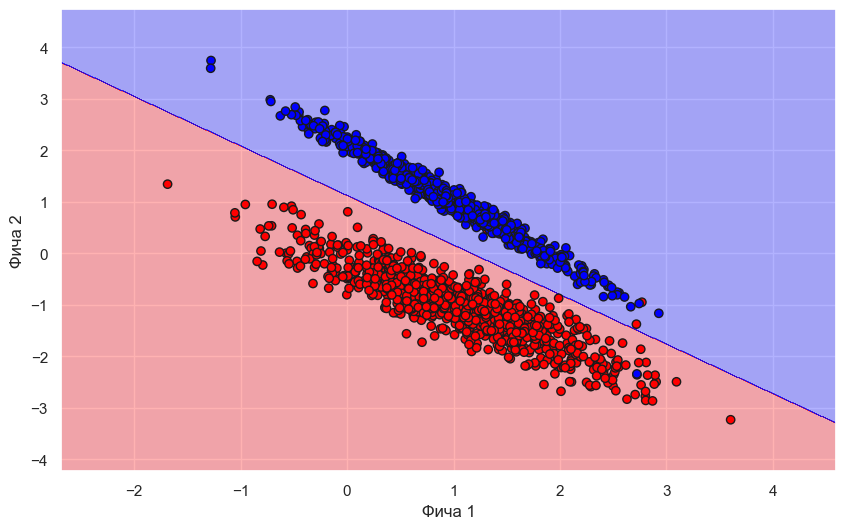

In [40]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [41]:
def plot_loss_history(model):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_history, label='Loss')
    plt.xlabel('Итерация')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

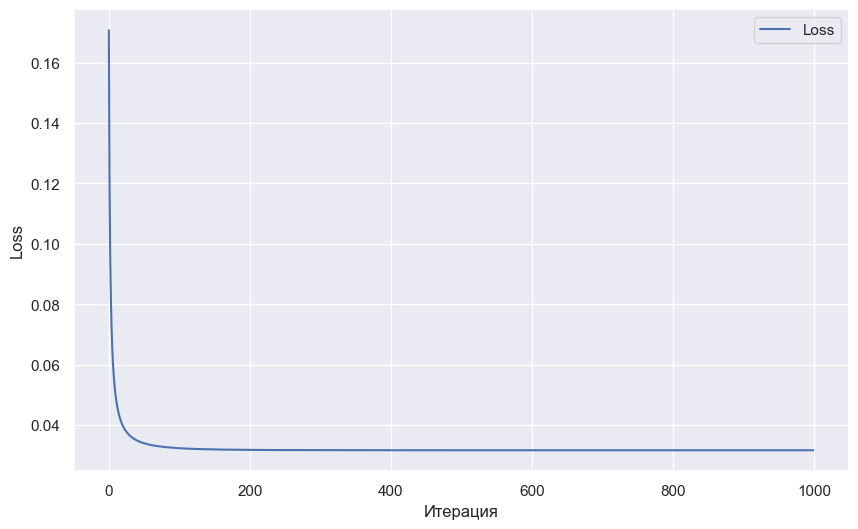

In [42]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

Kernel: linear, C: 0.1
Accuracy: 0.8050, Precision: 0.7895, Recall: 0.7979, F1-Score: 0.7937, AUC-ROC: 0.9125
------------------------------------------------------------
Kernel: linear, C: 1
Accuracy: 0.8100, Precision: 0.7979, Recall: 0.7979, F1-Score: 0.7979, AUC-ROC: 0.9124
------------------------------------------------------------
Kernel: linear, C: 10
Accuracy: 0.8100, Precision: 0.7979, Recall: 0.7979, F1-Score: 0.7979, AUC-ROC: 0.9123
------------------------------------------------------------
Kernel: rbf, C: 0.1
Accuracy: 0.8850, Precision: 0.8447, Recall: 0.9255, F1-Score: 0.8832, AUC-ROC: 0.9519
------------------------------------------------------------
Kernel: rbf, C: 1
Accuracy: 0.9350, Precision: 0.9091, Recall: 0.9574, F1-Score: 0.9326, AUC-ROC: 0.9854
------------------------------------------------------------
Kernel: rbf, C: 10
Accuracy: 0.9550, Precision: 0.9293, Recall: 0.9787, F1-Score: 0.9534, AUC-ROC: 0.9908
--------------------------------------------------

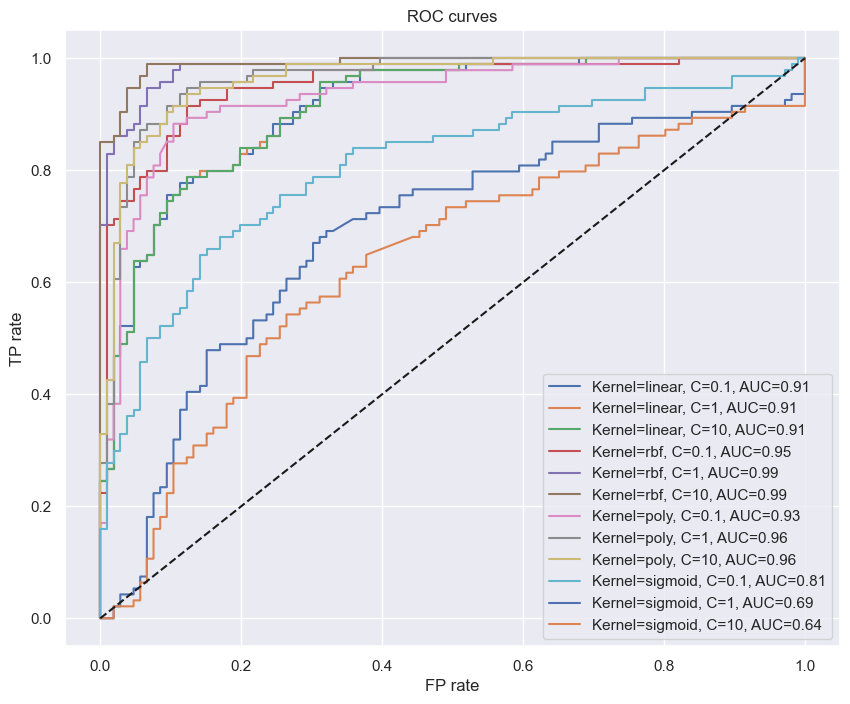

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification


X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
C_values = [0.1, 1, 10]

results = []

for kernel in kernels:
    for C in C_values:
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_probs)
        results.append({
            'Kernel': kernel,
            'C': C,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'AUC-ROC': auc
        })
        print(f"Kernel: {kernel}, C: {C}")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, "
              f"F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")
        print("-" * 60)

plt.figure(figsize=(10, 8))
for result in results:
    model = SVC(kernel=result['Kernel'], C=result['C'], probability=True, random_state=42)
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"Kernel={result['Kernel']}, C={result['C']}, AUC={result['AUC-ROC']:.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curves')
plt.legend()
plt.show()

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [44]:
from collections import Counter


class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        '''
        n_neighbors: Number of neighbors to use for kneighbors queries.
        metric: Distance metric to use ('euclidean' or 'manhattan').
        '''
        self.n_neighbors = n_neighbors
        self.metric = metric
        
    def fit(self, X, y):
        '''
        Fit the model using X as training data and y as target values.
        '''
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.classes_ = np.unique(y)
        
    def _compute_distance(self, X):
        '''
        Compute the distance between each test point in X and all training points.
        '''
        if self.metric == 'euclidean':
            distances = np.sqrt(((self.X_train - X[:, np.newaxis]) ** 2).sum(axis=2))
        elif self.metric == 'manhattan':
            distances = np.abs(self.X_train - X[:, np.newaxis]).sum(axis=2)
        else:
            raise ValueError("Умеем только 'euclidean' или 'manhattan'.")
        return distances
    
    def predict(self, X):
        '''
        Predict the class labels for the provided data.
        '''
        X = np.array(X)
        distances = self._compute_distance(X)
        nearest_neighbor_ids = distances.argsort(axis=1)[:, :self.n_neighbors]
        nearest_neighbor_labels = self.y_train[nearest_neighbor_ids]
        y_pred = np.array([Counter(labels).most_common(1)[0][0] for labels in nearest_neighbor_labels])
        return y_pred
    
    def predict_proba(self, X):
        '''
        Return probability estimates for the test data X.
        '''
        X = np.array(X)
        distances = self._compute_distance(X)
        nearest_neighbor_ids = distances.argsort(axis=1)[:, :self.n_neighbors]
        nearest_neighbor_labels = self.y_train[nearest_neighbor_ids]
        proba = []
        for labels in nearest_neighbor_labels:
            class_counts = Counter(labels)
            total_counts = sum(class_counts.values())
            class_proba = [class_counts.get(cls, 0) / total_counts for cls in self.classes_]
            proba.append(class_proba)
        return np.array(proba)


In [45]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

In [46]:
knn = KNNClassifier(n_neighbors=5, metric='euclidean')

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

y_probs = knn.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

print(f"Метрики KNN:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")


Метрики KNN:
Accuracy: 0.9000
Precision: 0.8558
Recall: 0.9468
F1-Score: 0.8990
AUC-ROC: 0.9661


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [47]:
data = pd.read_csv('train.csv')

print(f"df.shape: {data.shape}")

train_data = data.iloc[:50000]
test_data = data.iloc[50000:]

X_train = train_data.drop(['Category', 'Id'], axis=1).values
y_train = train_data['Category'].values

X_test = test_data.drop(['Category', 'Id'], axis=1).values
y_test = test_data['Category'].values

print(f"Training df shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing df shape: {X_test.shape}, Testing labels shape: {y_test.shape}")


df.shape: (60000, 786)
Training df shape: (50000, 784), Training labels shape: (50000,)
Testing df shape: (10000, 784), Testing labels shape: (10000,)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

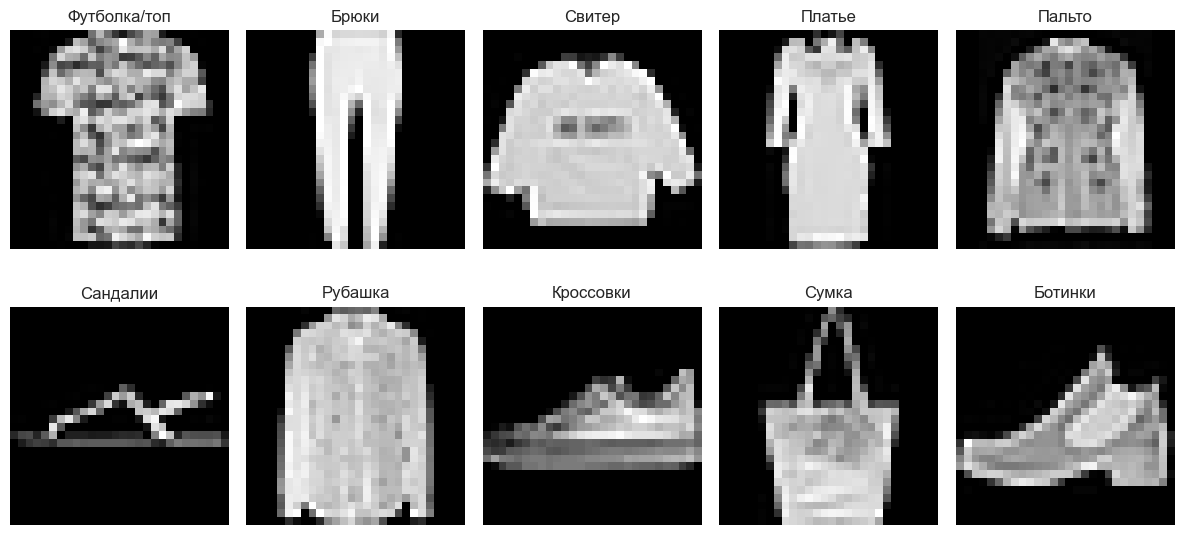

In [48]:
class_names = ['Футболка/топ', 'Брюки', 'Свитер', 'Платье', 'Пальто', 
               'Сандалии', 'Рубашка', 'Кроссовки', 'Сумка', 'Ботинки']

examples = {}
for label in np.unique(y_train):
    idx = np.where(y_train == label)[0][0]
    examples[label] = X_train[idx]

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(examples[i].reshape(28,28), cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


data = pd.read_csv('train.csv')
train_data = data.iloc[:50000]
test_data = data.iloc[50000:]

X_train = train_data.drop(['Category', 'Id'], axis=1).values
y_train = train_data['Category'].values

X_test = test_data.drop(['Category', 'Id'], axis=1).values
y_test = test_data['Category'].values

standard_scaler = StandardScaler()

X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

print("StandardScaler:")
print(f"Mean: {X_train_standard.mean(axis=0)[:5]}")
print(f"SD: {X_train_standard.std(axis=0)[:5]}")

minmax_scaler = MinMaxScaler()

X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

print("\nMinMaxScaler:")
print(f"Min по фичам: {X_train_minmax.min(axis=0)[:5]}")
print(f"Max по фичам: {X_train_minmax.max(axis=0)[:5]}")


StandardScaler:
Mean: [-6.76791956e-18 -1.66977543e-18  1.23456800e-18 -7.81597009e-18
 -1.42108547e-18]
SD: [1. 1. 1. 1. 1.]

MinMaxScaler:
Min по фичам: [0. 0. 0. 0. 0.]
Max по фичам: [1. 1. 1. 1. 1.]


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


In [51]:
data = pd.read_csv('train.csv')
train_data = data.iloc[:50000]
test_data = data.iloc[50000:]


X_train = train_data.drop(['Category', 'Id'], axis=1).values
y_train = train_data['Category'].values

X_test = test_data.drop(['Category', 'Id'], axis=1).values
y_test = test_data['Category'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Дисперсия: {explained_variance:.2%}")

Дисперсия: 80.05%


In [53]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [54]:
knn_grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [55]:
knn_grid_search.fit(X_train_pca, y_train)

print("Best KNN params:")
print(knn_grid_search.best_params_)
print(f"Best cross-validation accuracy: {knn_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best KNN params:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation accuracy: 0.8586


In [56]:
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['ovr', 'multinomial'],
    'max_iter': [100, 200]
}

In [57]:
logreg_grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=logreg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [58]:
logreg_grid_search.fit(X_train_pca, y_train)

print("\nBest LR params:")
print(logreg_grid_search.best_params_)
print(f"Best cross-validation accuracy: {logreg_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\vanya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best LR params:
{'C': 10, 'max_iter': 200, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.8321


c:\Users\vanya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
knn_best = knn_grid_search.best_estimator_

y_pred_knn = knn_best.predict(X_test_pca)

knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"\nKNN test accuracy: {knn_accuracy:.4f}")

print(classification_report(y_test, y_pred_knn))


KNN test accuracy: 0.8589
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1001
           1       0.99      0.97      0.98       996
           2       0.79      0.78      0.78      1004
           3       0.90      0.87      0.89      1017
           4       0.74      0.78      0.76       997
           5       0.95      0.88      0.91       971
           6       0.67      0.62      0.64       986
           7       0.89      0.93      0.91      1003
           8       0.97      0.95      0.96      1017
           9       0.91      0.95      0.93      1008

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [60]:
logreg_best = logreg_grid_search.best_estimator_

y_pred_logreg = logreg_best.predict(X_test_pca)

logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"\nLR test accuracy: {logreg_accuracy:.4f}")

print(classification_report(y_test, y_pred_logreg))


LR test accuracy: 0.8294
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1001
           1       0.96      0.96      0.96       996
           2       0.74      0.69      0.71      1004
           3       0.81      0.86      0.84      1017
           4       0.70      0.74      0.72       997
           5       0.89      0.92      0.91       971
           6       0.60      0.52      0.56       986
           7       0.90      0.89      0.90      1003
           8       0.95      0.93      0.94      1017
           9       0.94      0.93      0.93      1008

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [61]:
print(f"KNN: {knn_accuracy:.4f}")
print(f"LR: {logreg_accuracy:.4f}")

KNN: 0.8589
LR: 0.8294


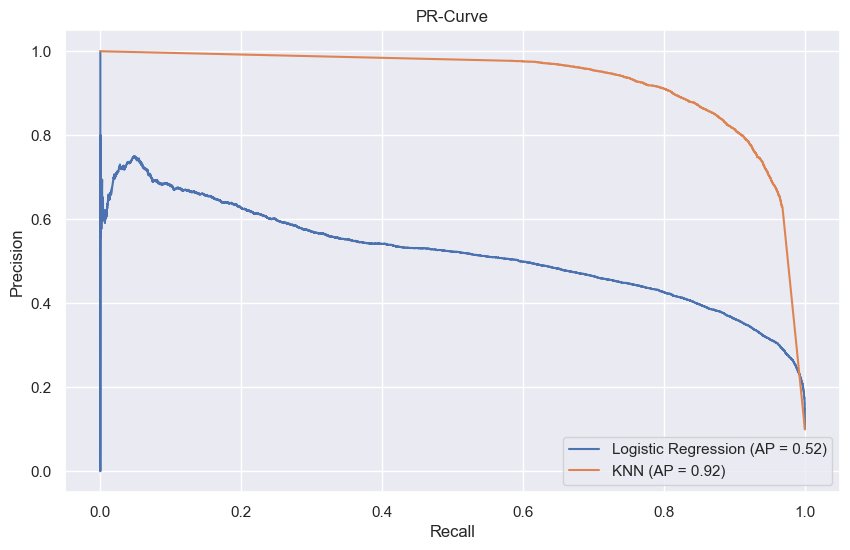

In [62]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_scores_logreg = logreg_best.decision_function(X_test_pca)
y_probs_knn = knn_best.predict_proba(X_test_pca)
y_test_binarized = label_binarize(y_test, classes=logreg_best.classes_)

precision_logreg, recall_logreg, _ = precision_recall_curve(y_test_binarized.ravel(),
                                                            y_scores_logreg.ravel())
average_precision_logreg = average_precision_score(y_test_binarized, y_scores_logreg, average='micro')
precision_knn, recall_knn, _ = precision_recall_curve(y_test_binarized.ravel(),
                                                      y_probs_knn.ravel())
average_precision_knn = average_precision_score(y_test_binarized, y_probs_knn, average='micro')

plt.figure(figsize=(10, 6))
plt.plot(recall_logreg, precision_logreg, label=f'Logistic Regression (AP = {average_precision_logreg:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {average_precision_knn:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-Curve')
plt.legend()
plt.grid(True)
plt.show()

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

**Ответ:**

При обучении логистической регрессии с SGD моделька не будет различать положительные и отрицательные классы, т.к. все объекты имеют одинаковые признаки. Следовательно модель будет предсказывать одинаковую вероятность $ P(y=1|x) = 0.5 $ для всех объектов.

$P(y=1|x) = \frac{1}{1 + e^{-(w^\top x + b)}}$

Все $x$ одинаковые $ \implies $ $w^\top x + b$ будет константой. При оптимизации функции потерь SGD $ w $ и $ b $ будут:

$w^\top x + b = 0 \implies P(y=1|x) = 0.5$

Итоговая модель будет эквивалентна подбросу монетки.


#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


data = pd.read_csv('train.csv')
train_data = data.iloc[:50000]
test_data = data.iloc[50000:]

X_train = train_data.drop(['Category', 'Id'], axis=1).values
y_train = train_data['Category'].values

X_test = test_data.drop(['Category', 'Id'], axis=1).values
y_test = test_data['Category'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=500, n_jobs=-1)
logreg.fit(X_train_scaled, y_train)

c:\Users\vanya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=-1)

In [64]:
weights = logreg.coef_

num_classes = weights.shape[0]
print(f"Количество классов: {num_classes}")

Количество классов: 10


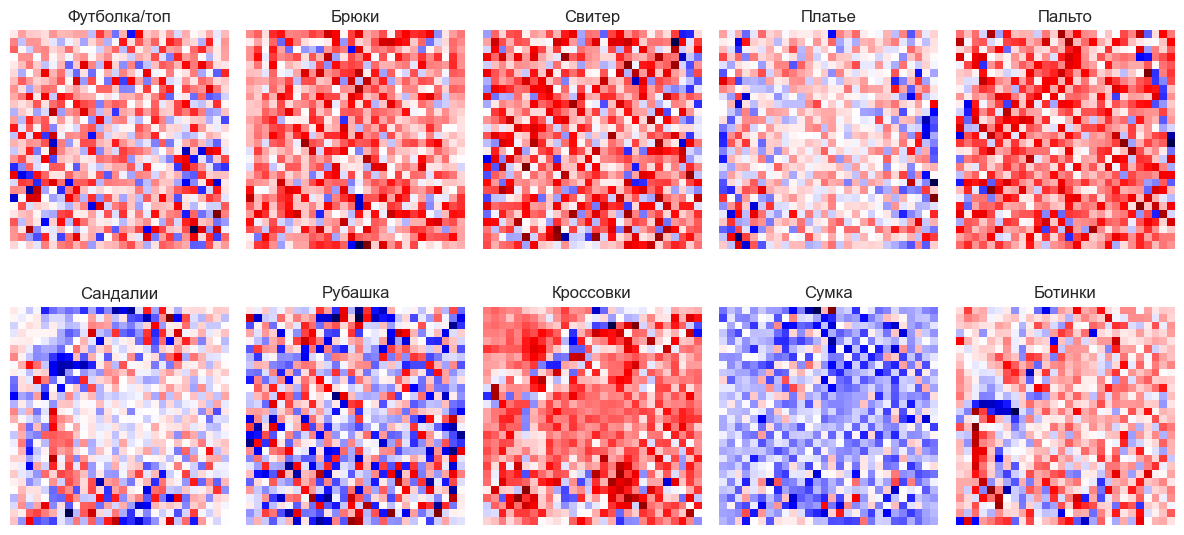

In [65]:
class_names = ['Футболка/топ', 'Брюки', 'Свитер', 'Платье', 'Пальто', 
               'Сандалии', 'Рубашка', 'Кроссовки', 'Сумка', 'Ботинки']

plt.figure(figsize=(12, 6))
for i in range(num_classes):
    weight_image = weights[i].reshape(28, 28)

    plt.subplot(2, 5, i+1)
    plt.imshow(weight_image, cmap='seismic', interpolation='nearest')
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('train.csv')
train_data = data.iloc[:50000]
test_data = data.iloc[50000:]

X_train_full = train_data.drop(['Category', 'Id'], axis=1).values
y_train_full = train_data['Category'].values

X_test = test_data.drop(['Category', 'Id'], axis=1).values
y_test = test_data['Category'].values

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_scaled, y_train_full, train_size=10000, stratify=y_train_full, random_state=42
)

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Random forest validation accuracy (baseline): {rf_accuracy:.4f}")

Random Forest validation accuracy (baseline): 0.8579


In [68]:
param_distributions = {
    'n_estimators': [100, 150],
    'max_depth': [None, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

print("Best params for random forest:")
print(random_search_rf.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params for random forest:
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [69]:
best_rf = random_search_rf.best_estimator_

y_pred_best_rf_val = best_rf.predict(X_val)
best_rf_accuracy_val = accuracy_score(y_val, y_pred_best_rf_val)
print(f"Best random forest validation accuracy: {best_rf_accuracy_val:.4f}")

best_rf_full = RandomForestClassifier(
    **random_search_rf.best_params_,
    random_state=42,
    n_jobs=-1
)
best_rf_full.fit(X_train_full_scaled, y_train_full)

y_pred_best_rf = best_rf_full.predict(X_test_scaled)
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
print(f"Best random forest test accuracy: {best_rf_accuracy:.4f}")

print(classification_report(y_test, y_pred_best_rf))

Best random forest validation accuracy: 0.8598
Best random forest test accuracy: 0.8848
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1001
           1       0.99      0.98      0.98       996
           2       0.80      0.83      0.81      1004
           3       0.89      0.92      0.90      1017
           4       0.77      0.83      0.80       997
           5       0.96      0.97      0.96       971
           6       0.75      0.59      0.66       986
           7       0.95      0.94      0.94      1003
           8       0.96      0.97      0.97      1017
           9       0.96      0.95      0.96      1008

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

